<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Evolving Maxwell's Equations with Toriodal Dipole Field Initial Data, in Flat Spacetime and Curvilinear Coordinates

## Following the work of [Knapp, Walker & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051), we numerically implement the second version of Maxwell’s equations - System II (BSSN - like) in curvilinear coordinates.

## Author: Terrence Pierre Jacques and Zachariah Etienne
### Formatting improvements courtesy Brandon Clark

**Notebook Status:** <font color = green><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to the exact solution for the electric field $E^i$ and vector potential $A^i$ at the expected order, *after a short numerical evolution of the initial data* (see [plots at bottom](#convergence)).

### NRPy+ Source Code for this module: 
* [Maxwell/InitialData.py](../edit/Maxwell/InitialData.py); [\[**tutorial**\]](Tutorial-VacuumMaxwell_InitialData.ipynb): Purely toriodal dipole field initial data; sets all electromagnetic variables in the Cartesian basis
* [Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear.py](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py); [\[**tutorial**\]](Tutorial-Tutorial-VacuumMaxwell_Curvilinear_RHS-Rescaling.ipynb): Generates the right-hand sides for Maxwell's equations in curvilinear coordinates

## Introduction:
Here we use NRPy+ to generate the C source code necessary to set up initial data for a purely toriodal dipole field, as defined in [Knapp, Walker & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051). We then evolve the RHSs of Maxwell's equations using the [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on an [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4 is chosen below, but multiple options exist). 

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration
    * [**NRPy+ tutorial on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on purely toriodal dipole field initial data**](Tutorial-VacuumMaxwell_InitialData.ipynb)
1. Next, integrate the initial data forward in time using the Method of Lines coupled to a Runge-Kutta explicit timestepping algorithm:
    1. At the start of each iteration in time, output the divergence constraint violation 
        * [**NRPy+ tutorial on Maxwell's equations constraints**](Tutorial-VacuumMaxwell_Curvilinear_RHSs.ipynb)
    1. At each RK time substep, do the following:
        1. Evaluate RHS expressions 
            * [**NRPy+ tutorial on Maxwell's equations right-hand sides**](Tutorial-VacuumMaxwell_Curvilinear_RHSs.ipynb)
        1. Apply Sommerfeld boundary conditions in curvilinear coordinates
            * [**NRPy+ tutorial on setting up Sommerfeld boundary conditions**](Tutorial-SommerfeldBoundaryCondition.ipynb)        
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
    1. [Step 1.a](#cfl) Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 2](#mw): Generate symbolic expressions and output C code for evolving Maxwell's equations
    1. [Step 2.a](#mwid): Generate symbolic expressions for toroidal dipole field initial data
    1. [Step 2.b](#mwevol): Generate symbolic expressions for evolution equations
    1. [Step 2.c](#mwcon): Generate symbolic expressions for constraint equations
    1. [Step 2.d](#mwcart): Generate symbolic expressions for converting $A^i$ and $E^i$ to the Cartesian basis
    1. [Step 2.e](#mwccode): Output C codes for initial data and evolution equations
    1. [Step 2.f](#mwccode_con): Output C code for constraint equations
    1. [Step 2.g](#mwccode_cart): Output C code for converting $A^i$ and $E^i$ to Cartesian coordinates
    1. [Step 2.h](#mwccode_xzloop): Output C code for printing 2D data
    1. [Step 2.i](#cparams_rfm_and_domainsize): Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
1. [Step 3](#bc_functs): Set up Sommerfeld boundary condition functions
1. [Step 4](#mainc): `Maxwell_Playground.c`: The Main C Code
1. [Step 5](#compileexec): Compile generated C codes & perform simulation of the propagating toriodal electromagnetic field
1. [Step 6](#visualize): Visualize the output!
    1. [Step 6.a](#installdownload): Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded
    1. [Step 6.b](#genimages): Generate images for visualization animation
    1. [Step 6.c](#genvideo): Generate visualization animation
1. [Step 7](#convergence): Plot the numerical error, and confirm that it converges to zero with increasing numerical resolution (sampling)
1. [Step 8](#div_e): Comparison of Divergence Constrain Violation
1. [Step 9](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import outputC,lhrh,outCfunction # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions, benchmarking

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("MaxwellEvolCurvi_Playground_Ccodes/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

# Step 1: Set the spatial dimension parameter
#         to three (BSSN is a 3+1 decomposition
#         of Einstein's equations), and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 2: Set some core parameters, including CoordSystem MoL BoundaryCondition timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "SinhCylindrical"

# Step  2.a: Set boundary conditions
# Current choices are QuadraticExtrapolation (quadratic polynomial extrapolation) or Sommerfeld
BoundaryCondition = "Sommerfeld"

# Step 2.b: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size     = 10.0 # Needed for all coordinate systems.

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05 # If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.c: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
default_CFL_FACTOR= 0.5      # (GETS OVERWRITTEN WHEN EXECUTED.) In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.

# Step 3: Generate Runge-Kutta-based (RK-based) timestepping code.
#       3.A: Evaluate RHSs (RHS_string)
#       3.B: Apply boundary conditions (RHS_string)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))

RHS_string = "rhs_eval(&rfmstruct, &params, RK_INPUT_GFS, RK_OUTPUT_GFS);"

if BoundaryCondition == "QuadraticExtrapolation":
    # Extrapolation BCs are applied to the evolved gridfunctions themselves after the MoL update
    post_RHS_string = "apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_OUTPUT_GFS);"
elif BoundaryCondition == "Sommerfeld":
    # Sommerfeld BCs are applied to the gridfunction RHSs directly
    RHS_string += "\n apply_bcs_sommerfeld(&params, xx, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_INPUT_GFS, RK_OUTPUT_GFS);"
    post_RHS_string = ""
else:
    print("Invalid choice of boundary condition")
    sys.exit(1)

MoL.MoL_C_Code_Generation(RK_method, RHS_string = RHS_string, post_RHS_string = post_RHS_string,
                          outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))


# Step 4: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric()

# Step 5: Set the finite differencing order to 4.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",FD_order)

# Step 6: Copy SIMD/SIMD_intrinsics.h to $Ccodesdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesdir,"SIMD/"))
# par.set_parval_from_str("indexedexp::symmetry_axes","2")

'MaxwellEvolCurvi_Playground_Ccodes/SIMD/SIMD_intrinsics.h'

<a id='cfl'></a>

## Step 1.a: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to Maxwell's equations to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [2]:
# Output the find_timestep() function to a C file.
rfm.out_timestep_func_to_file(os.path.join(Ccodesdir,"find_timestep.h"))

<a id='mw'></a>

# Step 2: Generate symbolic expressions and output C code for evolving Maxwell's equations \[Back to [top](#toc)\]
$$\label{mw}$$

Here we read in the symbolic expressions from the NRPy+ [InitialData](../edit/Maxwell/InitialData.py) and [Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear_rescaled](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear_rescaled.py) modules to define the initial data, evolution equations, and constraint equations.

<a id='mwid'></a>

## Step 2.a: Generate symbolic expressions for toroidal dipole field initial data \[Back to [top](#toc)\]
$$\label{mwid}$$



Here we use the NRPy+ [InitialData](../edit/Maxwell/InitialData.py) module, described in [this tutorial](Tutorial-VacuumMaxwell_InitialData.ipynb), to write initial data to the grid functions for both systems.

We define the rescaled quantities $a^i$ and $e^i$ in terms of $A^i$ and $E^i$ in curvilinear coordinates within the NRPy+ [InitialData](../edit/Maxwell/InitialData.py) module (see [this tutorial](Tutorial-VacuumMaxwell_formulation_Curvilinear.ipynb) for more detail);

\begin{align}
a^i &= \frac{A^i}{\text{ReU}[i]},\\ \\
e^i &= \frac{E^i}{\text{ReU}[i]}.
\end{align}

In [3]:
import Maxwell.InitialData as mwid

# Set which system to use, which are defined in Maxwell/InitialData.py
par.set_parval_from_str("Maxwell.InitialData::System_to_use","System_II")

mwid.InitialData()
aidU = ixp.zerorank1()
eidU = ixp.zerorank1()
for i in range(DIM):
    aidU[i] = mwid.AidU[i]/rfm.ReU[i]
    eidU[i] = mwid.EidU[i]/rfm.ReU[i]

Maxwell_ID_SymbExpressions = [\
                 lhrh(lhs="*AU0_exact",rhs=aidU[0]),\
                 lhrh(lhs="*AU1_exact",rhs=aidU[1]),\
                 lhrh(lhs="*AU2_exact",rhs=aidU[2]),\
                 lhrh(lhs="*EU0_exact",rhs=eidU[0]),\
                 lhrh(lhs="*EU1_exact",rhs=eidU[1]),\
                 lhrh(lhs="*EU2_exact",rhs=eidU[2]),\
                 lhrh(lhs="*PSI_exact",rhs=mwid.psi_ID),\
                 lhrh(lhs="*GAMMA_exact",rhs=mwid.Gamma_ID)]

Maxwell_ID_CcodeKernel = fin.FD_outputC("returnstring", Maxwell_ID_SymbExpressions)


Currently using System_II initial data


<a id='mwevol'></a>

## Step 2.b: Generate symbolic expressions for evolution equations \[Back to [top](#toc)\]
$$\label{mwevol}$$

Here we use the NRPy+ [Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear_rescaled](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear_rescaled.py) module, described in [this tutorial](Tutorial-VacuumMaxwell_Curvilinear_RHSs.ipynb), to ascribe the evolution equations to the grid functions.

In [4]:
import Maxwell.VacuumMaxwell_Flat_Evol_Curvilinear_rescaled as rhs

# Set which system to use, which are defined in Maxwell/InitialData.py
par.set_parval_from_str("Maxwell.InitialData::System_to_use","System_II")

cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

rhs.VacuumMaxwellRHSs_rescaled()

Maxwell_RHSs_SymbExpressions =  [\
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aU0"),rhs=rhs.arhsU[0]),\
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aU1"),rhs=rhs.arhsU[1]),\
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aU2"),rhs=rhs.arhsU[2]),\
                  lhrh(lhs=gri.gfaccess("rhs_gfs","eU0"),rhs=rhs.erhsU[0]),\
                  lhrh(lhs=gri.gfaccess("rhs_gfs","eU1"),rhs=rhs.erhsU[1]),\
                  lhrh(lhs=gri.gfaccess("rhs_gfs","eU2"),rhs=rhs.erhsU[2]),\
                  lhrh(lhs=gri.gfaccess("rhs_gfs","psi"),rhs=rhs.psi_rhs),\
                  lhrh(lhs=gri.gfaccess("rhs_gfs","Gamma"),rhs=rhs.Gamma_rhs)]

par.set_parval_from_str("reference_metric::enable_rfm_precompute","False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()

Maxwell_RHSs_string = fin.FD_outputC("returnstring",
                          Maxwell_RHSs_SymbExpressions,
                          params="SIMD_enable=True").replace("IDX4","IDX4S")


<a id='mwcon'></a>

## Step 2.c: Generate symbolic expressions for constraint equations \[Back to [top](#toc)\]
$$\label{mwcon}$$

We now use the NRPy+ [Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear_rescaled](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear_rescaled.py) module, described in [this tutorial](Tutorial-VacuumMaxwell_Curvilinear_RHSs.ipynb), to ascribe the constraint equations.

In [5]:
C = gri.register_gridfunctions("AUX", "C")
G = gri.register_gridfunctions("AUX", "G")

Constraints_string = fin.FD_outputC("returnstring",
                                [lhrh(lhs=gri.gfaccess("aux_gfs", "C"), rhs=rhs.C),
                                 lhrh(lhs=gri.gfaccess("aux_gfs", "G"), rhs=rhs.G)],
                                params="outCverbose=False").replace("IDX4","IDX4S")

<a id='mwcart'></a>

## Step 2.d: Generate symbolic expressions for converting $A^i$ and $E^i$ to the Cartesian basis \[Back to [top](#toc)\]
$$\label{mwcart}$$

We now use the NRPy+ [Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear_rescaled](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Curvilinear_rescaled.py) module, described in [this tutorial](Tutorial-VacuumMaxwell_Curvilinear_RHSs.ipynb), to ascribe the coordinate conversion, to make our convergence tests slightly easier.

In [6]:
AUCart = ixp.register_gridfunctions_for_single_rank1("AUX", "AUCart")
EUCart = ixp.register_gridfunctions_for_single_rank1("AUX", "EUCart")

Cartesian_Vectors_string = fin.FD_outputC("returnstring",
                        [lhrh(lhs=gri.gfaccess("aux_gfs", "AUCart0"), rhs=rhs.AU_Cart[0]),
                         lhrh(lhs=gri.gfaccess("aux_gfs", "AUCart1"), rhs=rhs.AU_Cart[1]),
                         lhrh(lhs=gri.gfaccess("aux_gfs", "AUCart2"), rhs=rhs.AU_Cart[2]),
                         lhrh(lhs=gri.gfaccess("aux_gfs", "EUCart0"), rhs=rhs.EU_Cart[0]),
                         lhrh(lhs=gri.gfaccess("aux_gfs", "EUCart1"), rhs=rhs.EU_Cart[1]),
                         lhrh(lhs=gri.gfaccess("aux_gfs", "EUCart2"), rhs=rhs.EU_Cart[2])],
                        params="outCverbose=False").replace("IDX4","IDX4S")

<a id='mwccode'></a>

## Step 2.e: Output C codes for initial data and evolution equations \[Back to [top](#toc)\]
$$\label{mwccode}$$

Next we write the C codes for the initial data and evolution equations to files, to be used later by our main C code.

In [7]:
# Step 11: Generate all needed C functions
Part_P1_body = Maxwell_ID_CcodeKernel
desc="Part P1: Declare the function for the exact solution at a single point. time==0 corresponds to the initial data."
name="exact_solution_single_point"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const REAL xx0,const REAL xx1,const REAL xx2,const paramstruct *restrict params,\
                                        REAL *EU0_exact, \
                                        REAL *EU1_exact, \
                                        REAL *EU2_exact, \
                                        REAL *AU0_exact, \
                                        REAL *AU1_exact, \
                                        REAL *AU2_exact, \
                                        REAL *PSI_exact,\
                                        REAL *GAMMA_exact",
    body     = Part_P1_body,
    loopopts = "")

desc="Part P2: Declare the function for the exact solution at all points. time==0 corresponds to the initial data."
name="exact_solution_all_points"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs",
    body     ="""
REAL xx0 = xx[0][i0]; REAL xx1 = xx[1][i1]; REAL xx2 = xx[2][i2];
exact_solution_single_point(xx0,xx1,xx2,params,&in_gfs[IDX4S(EU0GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(EU1GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(EU2GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AU0GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AU1GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AU2GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(PSIGF,i0,i1,i2)],
                                               &in_gfs[IDX4S(GAMMAGF,i0,i1,i2)]);""",
    loopopts = "AllPoints")

Part_P3_body = Maxwell_RHSs_string

desc="Part P3: Declare the function to evaluate the RHSs of Maxwell's equations"
name="rhs_eval"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="""rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                 const REAL *restrict in_gfs, REAL *restrict rhs_gfs""",
    body     =Part_P3_body,
    loopopts = "InteriorPoints,EnableSIMD,Enable_rfm_precompute")

Output C function exact_solution_single_point() to file MaxwellEvolCurvi_Playground_Ccodes/exact_solution_single_point.h
Output C function exact_solution_all_points() to file MaxwellEvolCurvi_Playground_Ccodes/exact_solution_all_points.h
Output C function rhs_eval() to file MaxwellEvolCurvi_Playground_Ccodes/rhs_eval.h


<a id='mwccode_con'></a>

## Step 2.f: Output C code for constraint equations \[Back to [top](#toc)\]
$$\label{mwccode_con}$$

Finally output the C code for evaluating the divergence constraint, described in [this tutorial](Tutorial-VacuumMaxwell_Curvilinear_RHSs.ipynb). In the absence of numerical error, this constraint should evaluate to zero, but due to numerical (typically truncation and roundoff) error it does not. We will therefore measure the divergence constraint violation to gauge the accuracy of our simulation, and ultimately determine whether errors are dominated by numerical finite differencing (truncation) error as expected. Specifically, we take the L2 norm of the constraint violation, via

\begin{align}
    \lVert C \rVert^2 &= \frac{\int C^2 d\mathcal{V}}{\int d\mathcal{V}}.
\end{align}

Numerically approximating this integral, in spherical coordinates for example, then gives us
    
\begin{align}
    \lVert C \rVert^2   &= \frac{\sum C^2 r^2 \sin^2 (\theta) dr d\theta d\phi}{\sum r^2 \sin^2 (\theta) dr d\theta d\phi}, \\ \\
    &= \frac{\sum C^2 r^2 \sin^2 (\theta)}{\sum r^2 \sin^2 (\theta) } , \\  \\
    &= \frac{\sum C^2 \ \sqrt{\text{det} \ \hat{\gamma}}}{\sum \sqrt{\text{det} \ \hat{\gamma}}},
\end{align}

where $\hat{\gamma}$ is the reference metric. Thus, along with the C code to calculate the constraints, we also print out the code required to evaluate $\sqrt{\text{det} \ \hat{\gamma}}$ at any given point.

In [8]:
# Set up the C function for the calculating the constraints
Part_P4_body = Constraints_string
desc="Evaluate the constraints"
name="Constraints"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                  REAL *restrict in_gfs, REAL *restrict aux_gfs""",
    body     = Part_P4_body,
    loopopts = "InteriorPoints,Enable_rfm_precompute")

# intgrand to be used to calculate the L2 norm of the constraint
diagnostic_integrand_body = outputC(rfm.detgammahat,"*detg",filename='returnstring',
                                    params="includebraces=False")
desc="Evaluate the volume element at a specific point"
name="diagnostic_integrand"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const REAL xx0,const REAL xx1,const REAL xx2,const paramstruct *restrict params, REAL *restrict detg",
    body     = diagnostic_integrand_body,
    loopopts = "")


Output C function Constraints() to file MaxwellEvolCurvi_Playground_Ccodes/Constraints.h
Output C function diagnostic_integrand() to file MaxwellEvolCurvi_Playground_Ccodes/diagnostic_integrand.h


<a id='mwccode_cart'></a>

## Step 2.g: Output C code for converting $A^i$ and $E^i$ to Cartesian coordinates \[Back to [top](#toc)\]
$$\label{mwccode_cart}$$

Here we write the C code for the coordinate transformation to Cartesian coordinates.

In [9]:
desc="Convert EU and AU to Cartesian basis"
name="Cartesian_basis"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params, REAL *restrict xx[3],
                  REAL *restrict in_gfs, REAL *restrict aux_gfs""",
    body     = "REAL xx0 = xx[0][i0]; REAL xx1 = xx[1][i1]; REAL xx2 = xx[2][i2];\n"+Cartesian_Vectors_string,
    loopopts = "AllPoints, Enable_rfm_precompute")

Output C function Cartesian_basis() to file MaxwellEvolCurvi_Playground_Ccodes/Cartesian_basis.h


<a id='mwccode_xzloop'></a>

## Step 2.h: Output C code for printing 2D data \[Back to [top](#toc)\]
$$\label{mwccode_xzloop}$$

Here we output the neccesary C code to print out a 2D slice of the data in the xz-plane, using the `xz_loop` macro

In [10]:
def xz_loop(CoordSystem):
    ret = """// xz-plane output for """ + CoordSystem + r""" coordinates:
#define LOOP_XZ_PLANE(ii, jj, kk) \
"""
    if "Spherical" in CoordSystem or  "SymTP" in CoordSystem:
        ret += r"""for (int i2 = 0; i2 < Nxx_plus_2NGHOSTS2; i2++) \
  if(i2 == NGHOSTS || i2 == Nxx_plus_2NGHOSTS2/2) \
    for (int i1 = 0; i1 < Nxx_plus_2NGHOSTS1; i1++) \
      for (int i0 = 0; i0 < Nxx_plus_2NGHOSTS0; i0++)
"""
    elif "Cylindrical" in CoordSystem:
        ret += r"""for (int i2 = 0; i2 < Nxx_plus_2NGHOSTS2; i2++) \
  for (int i1 = 0; i1 < Nxx_plus_2NGHOSTS1; i1++) \
    if(i1 == NGHOSTS || i1 == Nxx_plus_2NGHOSTS1/2) \
      for (int i0 = 0; i0 < Nxx_plus_2NGHOSTS0; i0++)
"""
    elif "Cartesian" in CoordSystem:
        ret += r"""for (int i2 = 0; i2 < Nxx_plus_2NGHOSTS2; i2++) \
  for (int i1 = Nxx_plus_2NGHOSTS1/2; i1 < Nxx_plus_2NGHOSTS1/2+1; i1++) \
    for (int i0 = 0; i0 < Nxx_plus_2NGHOSTS0; i0++)
"""
    return ret

with open(os.path.join(Ccodesdir,"xz_loop.h"),"w") as file:
    file.write(xz_loop(CoordSystem))

<a id='cparams_rfm_and_domainsize'></a>

## Step 2.i: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [11]:
# Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

# Set free_parameters.h
with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write("""
// Set free-parameter values.
params.time = 0.0; // Initial simulation time time corresponds to exact solution at time=0.
params.amp = 1.0;
params.lam = 1.0;
params.wavespeed = 1.0;\n""")

# Append to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

# Generate set_Nxx_dxx_invdx_params__and__xx.h:
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir, grid_centering="cell")

# Generate xxCart.h, which contains xxCart() for
#  (the mapping from xx->Cartesian) for the chosen CoordSystem:
rfm.xxCart_h("xxCart","./set_Cparameters.h",os.path.join(Ccodesdir,"xxCart.h"))

# Step 3.d.v: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

<a id='bc_functs'></a>

# Step 3: Set up Sommerfeld boundary condition for Cartesian coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next we output the C code necessary to implement the Sommerfeld boundary condition in Cartesian coordinates, [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-SommerfeldBoundaryCondition.ipynb)

In [12]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),
                                   Cparamspath=os.path.join("../"),
                                   BoundaryCondition=BoundaryCondition)

if BoundaryCondition == "Sommerfeld":
    bcs = cbcs.sommerfeld_boundary_condition_class(fd_order=4,
                                             vars_radial_falloff_power_default=3,
                                             vars_speed_default=1.,
                                             vars_at_inf_default=0.)
    bcs.write_sommerfeld_file(Ccodesdir)

Wrote to file "MaxwellEvolCurvi_Playground_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( Gamma:0, aU0:1, aU1:2, aU2:3, eU0:1, eU1:2, eU2:3, psi:0
    )
Auxiliary parity: ( AUCart0:1, AUCart1:2, AUCart2:3, C:0, EUCart0:1,
    EUCart1:2, EUCart2:3, G:0 )

Wrote to file "MaxwellEvolCurvi_Playground_Ccodes/boundary_conditions/EigenCoord_Cart_to_xx.h"

Successfully generated Sommerfeld boundary condition C code


<a id='mainc'></a>

# Step 4: `Maxwell_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

In [13]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER),
#          and set the CFL_FACTOR (which can be overwritten at the command line)

with open(os.path.join(Ccodesdir,"Maxwell_Playground_REAL__NGHOSTS__CFL_FACTOR.h"), "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"""
// Part P0.c: Set the CFL Factor. Can be overwritten at command line.
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+";")

In [14]:
%%writefile $Ccodesdir/Maxwell_Playground.c

// Step P0: Define REAL and NGHOSTS; and declare CFL_FACTOR. This header is generated in NRPy+.
#include "Maxwell_Playground_REAL__NGHOSTS__CFL_FACTOR.h"

#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

// All SIMD intrinsics used in SIMD-enabled C code loops are defined here:
#include "SIMD/SIMD_intrinsics.h"

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i"
//           (all other indices held to a fixed value) are consecutive in memory, where
//           consecutive values of "j" (fixing all other indices) are separated by
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Step P3: Set UUGF and VVGF macros, as well as xxCart()
#include "boundary_conditions/gridfunction_defines.h"

// Step P4: Defines set_Nxx_dxx_invdx_params__and__xx(const int EigenCoord, const int Nxx[3],
//                                       paramstruct *restrict params, REAL *restrict xx[3]),
//          which sets params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for
//          the chosen Eigen-CoordSystem if EigenCoord==1, or
//          CoordSystem if EigenCoord==0.
#include "set_Nxx_dxx_invdx_params__and__xx.h"

// Step P5: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

// Step P6: Find the CFL-constrained timestep
#include "find_timestep.h"

// Part P7: Declare the function for the exact solution at a single point. time==0 corresponds to the initial data.
#include "exact_solution_single_point.h"

// Part P8: Declare the function for the exact solution at all points. time==0 corresponds to the initial data.
#include "exact_solution_all_points.h"

// Step P9: Declare function for evaluating constraints (diagnostic)
#include "Constraints.h"

// Step P10: Declare rhs_eval function, which evaluates the RHSs of Maxwells equations
#include "rhs_eval.h"

// Step P11: Declare function to calculate det gamma_hat, used in calculating the L2 norm
#include "diagnostic_integrand.h"

// Step P12: Declare function to transform to the Cartesian basis
#include "Cartesian_basis.h"

// Step P13: Declare macro to print out data along the xz-plane
#include "xz_loop.h"

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
//         Lines timestepping algorithm, and output periodic simulation diagnostics
// Step 3.a: Output 2D data file periodically, for visualization
// Step 3.b: Step forward one timestep (t -> t+dt) in time using
//           chosen RK-like MoL timestepping algorithm
// Step 3.c: If t=t_final, output x and y components of evolution variables and the
//           constraint violation to 2D data file
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"

    // Define xxCart(const paramstruct *restrict params,
    //                     REAL *restrict xx[3],
    //                     const int i0,const int i1,const int i2,
    //                     REAL xCart[3]),
    //           which maps xx->Cartesian via
    //    {xx[0][i0],xx[1][i1],xx[2][i2]}->{xCart[0],xCart[1],xCart[2]}
    // Note that xxCart is declared inline, so it must be #include'd here since we call
    //  it from the main() function.
#include "xxCart.h"

    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 5 && argc != 6) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./Maxwell_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    if(argc == 5) {
        CFL_FACTOR = strtod(argv[5],NULL);
        if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
            fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
            fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
            fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
        }
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }

    // Step 0c: Set free parameters, overwriting Cparameters defaults
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"

   // Step 0d: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];
    // Step 0d.i: Set bcstruct
    bc_struct bcstruct;
    {
        int EigenCoord = 1;
        // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
        //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
        //             chosen Eigen-CoordSystem.
        set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
        // Step 0d.iii: Set Nxx_plus_2NGHOSTS_tot
#include "set_Cparameters-nopointer.h"
        const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
        // Step 0e: Find ghostzone mappings; set up bcstruct
#include "boundary_conditions/driver_bcstruct.h"
        // Step 0e.i: Free allocated space for xx[][] array
        for(int i=0;i<3;i++) free(xx[i]);
    }

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0g: Set all C parameters "blah" for params.blah, including
    //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0h: Time coordinate parameters
    const REAL t_final = strtod(argv[4],NULL);

    // Step 0i: Set timestep based on smallest proper distance between gridpoints and CFL factor
    REAL dt = find_timestep(&params, xx);
    //fprintf(stderr,"# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of points in time.
                                             // Add 0.5 to account for C rounding down
                                             // typecasts to integers.
    int output_every_N = (int)((REAL)N_final/800.0);
    if(output_every_N == 0) output_every_N = 1;

    // Step 0j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
    //              This is a limitation of the RK method. You are always welcome to declare & allocate
    //              additional gridfunctions by hand.
    if(NUM_AUX_GFS > NUM_EVOL_GFS) {
        fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
        fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
        exit(1);
    }

    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    REAL *restrict y_0_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *restrict diagnostic_output_gfs_0 = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0l: Set up precomputed reference metric arrays
    // Step 0l.i: Allocate space for precomputed reference metric arrays.
#include "rfm_files/rfm_struct__malloc.h"

    // Step 0l.ii: Define precomputed reference metric arrays.
    {
    #include "set_Cparameters-nopointer.h"
    #include "rfm_files/rfm_struct__define.h"
    }

    LOOP_ALL_GFS_GPS(i) {
     y_n_gfs[i] = 0.0/0.0;
}

    // Step 1: Set up initial data to be exact solution at time=0:
    params.time = 0.0;
    exact_solution_all_points(&params, xx, y_n_gfs);

    // Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
    // http://www.cplusplus.com/reference/ctime/time/
    time_t start_timer,end_timer;
    time(&start_timer); // Resolution of one second...
#endif

    // Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
    //         Lines timestepping algorithm, and output periodic simulation diagnostics
    for(int n=0;n<=N_final+1;n++) { // Main loop to progress forward in time.

       // At each timestep, set Constraints to NaN in the grid interior
        LOOP_REGION(NGHOSTS,NGHOSTS+Nxx0,
                    NGHOSTS,NGHOSTS+Nxx1,
                    NGHOSTS,NGHOSTS+Nxx2) {
                    const int idx = IDX3S(i0,i1,i2);
                    diagnostic_output_gfs[IDX4ptS(CGF,idx)] = 0.0/0.0;
            }

        // Step 3.a: Output 2D data file periodically, for visualization
        params.time = ((REAL)n)*dt;
        // Evaluate Divergence constraint violation
        Constraints(&rfmstruct, &params, y_n_gfs, diagnostic_output_gfs);
        // log_L2_Norm = log10( sqrt[Integral( [numerical - exact]^2 * dV)] )
        REAL L2Norm_sum_C = 0.;
        int sum = 0;
        LOOP_REGION(NGHOSTS,NGHOSTS+Nxx0,
                    NGHOSTS,NGHOSTS+Nxx1,
                    NGHOSTS,NGHOSTS+Nxx2) {
            const int idx = IDX3S(i0,i1,i2);
            double C = (double)diagnostic_output_gfs[IDX4ptS(CGF,idx)];
            REAL xx0 = xx[0][i0];
            REAL xx1 = xx[1][i1];
            REAL xx2 = xx[2][i2];
            REAL detghat; diagnostic_integrand(xx0, xx1, xx2, &params, &detghat);
            L2Norm_sum_C += C*C*sqrt(detghat);
            sum = sum + sqrt(detghat);
        }
        REAL L2Norm_C = sqrt(L2Norm_sum_C/(sum));
        printf("%e %.15e\n",params.time, L2Norm_C);

    // Step 3.a: Output 2D data file periodically, for visualization
       if(n%20 == 0) {
            exact_solution_all_points(&params, xx, y_0_gfs);
            Cartesian_basis(&rfmstruct, &params, xx, y_n_gfs, diagnostic_output_gfs);
            Cartesian_basis(&rfmstruct, &params, xx, y_0_gfs, diagnostic_output_gfs_0);
            char filename[100];
            sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
            FILE *out2D = fopen(filename, "w");
            LOOP_XZ_PLANE(ii, jj, kk){
            REAL xCart[3];
            xxCart(&params,xx,i0,i1,i2,xCart);
            int idx = IDX3S(i0,i1,i2);
            REAL Ex_num  = (double)diagnostic_output_gfs[IDX4ptS(EUCART0GF,idx)];
            REAL Ey_num  = (double)diagnostic_output_gfs[IDX4ptS(EUCART1GF,idx)];
            REAL Ax_num  = (double)diagnostic_output_gfs[IDX4ptS(AUCART0GF,idx)];
            REAL Ay_num  = (double)diagnostic_output_gfs[IDX4ptS(AUCART1GF,idx)];
            double C = (double)diagnostic_output_gfs[IDX4ptS(CGF,idx)];

            fprintf(out2D,"%e %e %e %.15e %.15e %.15e %.15e %.15e\n", params.time,
                    xCart[0],xCart[2], Ex_num, Ey_num, Ax_num, Ay_num, C);
       }
        fclose(out2D);
    }

      if(n==N_final-1) {
            exact_solution_all_points(&params, xx, y_0_gfs);
            Cartesian_basis(&rfmstruct, &params, xx, y_n_gfs, diagnostic_output_gfs);
            Cartesian_basis(&rfmstruct, &params, xx, y_0_gfs, diagnostic_output_gfs_0);
            char filename[100];
            sprintf(filename,"out%d.txt",Nxx[0]);
            FILE *out2D = fopen(filename, "w");
            LOOP_XZ_PLANE(ii, jj, kk){
            REAL xCart[3];
            xxCart(&params,xx,i0,i1,i2,xCart);
            int idx = IDX3S(i0,i1,i2);
            REAL Ex_num  = (double)diagnostic_output_gfs[IDX4ptS(EUCART0GF,idx)];
            REAL Ey_num  = (double)diagnostic_output_gfs[IDX4ptS(EUCART1GF,idx)];

            REAL Ax_num  = (double)diagnostic_output_gfs[IDX4ptS(AUCART0GF,idx)];
            REAL Ay_num  = (double)diagnostic_output_gfs[IDX4ptS(AUCART1GF,idx)];

            REAL Ex_exact  = (double)diagnostic_output_gfs_0[IDX4ptS(EUCART0GF,idx)];
            REAL Ey_exact  = (double)diagnostic_output_gfs_0[IDX4ptS(EUCART1GF,idx)];

            REAL Ax_exact  = (double)diagnostic_output_gfs_0[IDX4ptS(AUCART0GF,idx)];
            REAL Ay_exact  = (double)diagnostic_output_gfs_0[IDX4ptS(AUCART1GF,idx)];

            REAL Ex__E_rel = log10(fabs(Ex_num - Ex_exact));
            REAL Ey__E_rel = log10(fabs(Ey_num - Ey_exact));
            REAL Ax__E_rel = log10(fabs(Ax_num - Ax_exact));
            REAL Ay__E_rel = log10(fabs(Ay_num - Ay_exact));

            fprintf(out2D,"%e %e %.15e %.15e %.15e %.15e\n",xCart[0],xCart[2],
                     Ex__E_rel, Ey__E_rel, Ax__E_rel, Ay__E_rel);
       }
        fclose(out2D);
    }
        // Step 3.b: Step forward one timestep (t -> t+dt) in time using
        //           chosen RK-like MoL timestepping algorithm
#include "MoLtimestepping/RK_MoL.h"


        // Step 3.d: Progress indicator printing to stderr

        // Step 3.d.i: Measure average time per iteration
#ifdef __linux__ // Use high-precision timer in Linux.
        clock_gettime(CLOCK_REALTIME, &end);
        const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
        time(&end_timer); // Resolution of one second...
        REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
        const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

        const int iterations_remaining = N_final - n;
        const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

        const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
        const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

        // Step 3.d.ii: Output simulation progress to stderr
        if(n % 10 == 0) {
            fprintf(stderr,"%c[2K", 27); // Clear the line
            fprintf(stderr,"It: %d t=%.2f dt=%.2e | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
                   n, n * (double)dt, (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
                   (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
            fflush(stderr); // Flush the stderr buffer
        } // End progress indicator if(n % 10 == 0)

    } // End main loop to progress forward in time.
    fprintf(stderr,"\n"); // Clear the final line of output from progress indicator.

    // Step 4: Free all allocated memory
#include "rfm_files/rfm_struct__freemem.h"
#include "boundary_conditions/bcstruct_freemem.h"
#include "MoLtimestepping/RK_Free_Memory.h"
    free(y_0_gfs);
    free(diagnostic_output_gfs_0);
    for(int i=0;i<3;i++) free(xx[i]);

    return 0;
}

Writing MaxwellEvolCurvi_Playground_Ccodes//Maxwell_Playground.c


<a id='compileexec'></a>

# Step 5: Compile generated C codes & perform simulation of the propagating toriodal electromagnetic field \[Back to [top](#toc)\]
$$\label{compileexec}$$

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [15]:
import cmdline_helper as cmd
CFL_FACTOR=0.5
cmd.C_compile(os.path.join(Ccodesdir,"Maxwell_Playground.c"),
              os.path.join(outdir,"Maxwell_Playground"),compile_mode="optimized")

Compiling executable...
(EXEC): Executing `gcc -Ofast -fopenmp -march=native -funroll-loops MaxwellEvolCurvi_Playground_Ccodes/Maxwell_Playground.c -o MaxwellEvolCurvi_Playground_Ccodes/output/Maxwell_Playground -lm`...
(BENCH): Finished executing in 2.0446927547454834 seconds.
Finished compilation.


In [16]:
# Change to output directory
os.chdir(outdir)

In [17]:
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
cmd.delete_existing_files("out-*resolution.txt")

In [18]:
# Set tme to end simulation
t_final = str(0.5*domain_size) + ' '

# Run executables
if 'Spherical' in CoordSystem  or 'SymTP' in CoordSystem:
    cmd.Execute("Maxwell_Playground", "64 48 4 "+t_final+str(CFL_FACTOR), "out-lowresolution.txt")
    cmd.Execute("Maxwell_Playground", "96 72 4 "+t_final+str(CFL_FACTOR), "out-medresolution.txt")
    Nxx0_low = '64'
    Nxx0_med = '96'

elif 'Cylindrical' in CoordSystem:
    cmd.Execute("Maxwell_Playground", "50 4 100 "+t_final+str(CFL_FACTOR), "out-lowresolution.txt")
    cmd.Execute("Maxwell_Playground", "80 4 160 "+t_final+str(CFL_FACTOR), "out-medresolution.txt")
    Nxx0_low = '50'
    Nxx0_med = '80'

else:
    # Cartesian
    cmd.Execute("Maxwell_Playground", "64 64 64 "+t_final+str(CFL_FACTOR), "out-lowresolution.txt")
    cmd.Execute("Maxwell_Playground", "128 128 128 "+t_final+str(CFL_FACTOR), "out-medresolution.txt")
    Nxx0_low = '64'
    Nxx0_med = '128'

(EXEC): Executing `taskset -c 0,1,2,3,4,5 ./Maxwell_Playground 50 4 100 5.0 0.5`...
It: 150 t=4.87 dt=3.25e-02 | 97.4%; ETA 0 s | t/h 6963.28 | gp/s 4.77e+06
(BENCH): Finished executing in 2.613574981689453 seconds.
(EXEC): Executing `taskset -c 0,1,2,3,4,5 ./Maxwell_Playground 80 4 160 5.0 0.5`...
It: 240 t=4.87 dt=2.03e-02 | 97.6%; ETA 0 s | t/h 2137.90 | gp/s 6.00e+06
(BENCH): Finished executing in 8.6272451877594 seconds.


In [19]:
# Return to root directory
os.chdir(os.path.join("../../"))

print("Finished this code cell.")

Finished this code cell.


<a id='visualize'></a>

# Step 6: Visualize the output! \[Back to [top](#toc)\]
$$\label{visualize}$$ 

In this section we will generate a movie, plotting the x component of the electric field on a 2D grid..

<a id='installdownload'></a>

## Step 6.a: Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded \[Back to [top](#toc)\]
$$\label{installdownload}$$ 

Note that if you are not running this within `mybinder`, but on a Windows system, `ffmpeg` must be installed using a separate package (on [this site](http://ffmpeg.org/)), or if running Jupyter within Anaconda, use the command: `conda install -c conda-forge ffmpeg`.

In [20]:
!pip install scipy > /dev/null

check_for_ffmpeg = !which ffmpeg >/dev/null && echo $?
if check_for_ffmpeg != ['0']:
    print("Couldn't find ffmpeg, so I'll download it.")
    # Courtesy https://johnvansickle.com/ffmpeg/
    !wget http://astro.phys.wvu.edu/zetienne/ffmpeg-static-amd64-johnvansickle.tar.xz
    !tar Jxf ffmpeg-static-amd64-johnvansickle.tar.xz
    print("Copying ffmpeg to ~/.local/bin/. Assumes ~/.local/bin is in the PATH.")
    !mkdir ~/.local/bin/
    !cp ffmpeg-static-amd64-johnvansickle/ffmpeg ~/.local/bin/
    print("If this doesn't work, then install ffmpeg yourself. It should work fine on mybinder.")

<a id='genimages'></a>

## Step 6.b: Generate images for visualization animation \[Back to [top](#toc)\]
$$\label{genimages}$$ 

Here we loop through the data files output by the executable compiled and run in [the previous step](#mainc), generating a [png](https://en.wikipedia.org/wiki/Portable_Network_Graphics) image for each data file.

**Special thanks to Terrence Pierre Jacques. His work with the first versions of these scripts greatly contributed to the scripts as they exist below.**

In [21]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

globby = glob.glob(os.path.join(outdir,'out'+Nxx0_med+'-00*.txt'))
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound = domain_size/2.0
pl_xmin = -bound
pl_xmax = +bound
pl_zmin = -bound
pl_zmax = +bound

for filename in file_list:
    fig = plt.figure()
    t, x, z, Ex, Ey, Ax, Ay, C = np.loadtxt(filename).T #Transposed for easier unpacking

    plotquantity = Ex
    time = np.round(t[0], decimals=3)
    plotdescription = "Numerical Soln."
    plt.title(r"$E_x$ at $t$ = "+str(time))
    plt.xlabel("x")
    plt.ylabel("z")

    grid_x, grid_z = np.mgrid[pl_xmin:pl_xmax:200j, pl_zmin:pl_zmax:200j]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = x[i]
        points[i][1] = z[i]

    grid = griddata(points, plotquantity, (grid_x, grid_z), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_z), method='cubic')
    im = plt.imshow(gridcub, extent=(pl_xmin,pl_xmax, pl_zmin,pl_zmax))
    ax = plt.colorbar()
    plt.clim(-3,3)
    ax.set_label(plotdescription)
    savefig(os.path.join(filename+".png"),dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+filename+"\r")
    sys.stdout.flush()

<a id='genvideo'></a>

## Step 6.c: Generate visualization animation \[Back to [top](#toc)\]
$$\label{genvideo}$$ 

In the following step, [ffmpeg](http://ffmpeg.org) is used to generate an [mp4](https://en.wikipedia.org/wiki/MPEG-4) video file, which can be played directly from this Jupyter notebook.

In [22]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save(os.path.join(outdir,'Maxwell_ToroidalDipole.mp4'), fps=5,dpi=150)

In [23]:
## VISUALIZATION ANIMATION, PART 3: Display movie as embedded HTML5 (see next cell) ##

# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

In [24]:
# Embed video based on suggestion:
#  https://stackoverflow.com/questions/39900173/jupyter-notebook-html-cell-magic-with-python-variable
HTML("""
<video width="480" height="360" controls>
  <source src=\""""+os.path.join(outdir,"Maxwell_ToroidalDipole.mp4")+"""\" type="video/mp4">
</video>
""")

<a id='convergence'></a>

# Step 7: Plot the numerical error, and confirm that it converges to zero with increasing numerical resolution (sampling) \[Back to [top](#toc)\]
$$\label{convergence}$$

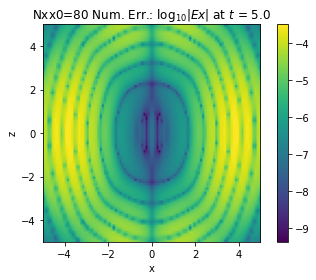

In [25]:
x_med, z_med, Ex__E_rel_med, Ey__E_rel_med, Ax__E_rel_med, Ay__E_rel_med = np.loadtxt(os.path.join(outdir,'out'+Nxx0_med+'.txt')).T #Transposed for easier unpacking

pl_xmin = -domain_size/2.
pl_xmax = +domain_size/2.
pl_ymin = -domain_size/2.
pl_ymax = +domain_size/2.

grid_x, grid_z = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points_med = np.zeros((len(x_med), 2))
for i in range(len(x_med)):
    points_med[i][0] = x_med[i]
    points_med[i][1] = z_med[i]

grid_med = griddata(points_med, Ex__E_rel_med, (grid_x, grid_z), method='nearest')
grid_medcub = griddata(points_med, Ex__E_rel_med, (grid_x, grid_z), method='cubic')

plt.clf()
plt.title(r"Nxx0="+Nxx0_med+" Num. Err.: $\log_{10}|Ex|$ at $t$ = "+t_final)
plt.xlabel("x")
plt.ylabel("z")

fig_medcub = plt.imshow(grid_medcub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig_medcub)

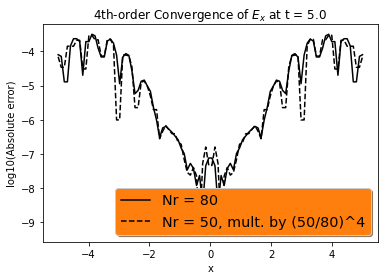

In [26]:
x_low,z_low, EU0__E_rel_low, EU1__E_rel_low, AU0__E_rel_low, AU1__E_rel_low = np.loadtxt(os.path.join(outdir,'out'+Nxx0_low+'.txt')).T #Transposed for easier unpacking

points_low = np.zeros((len(x_low), 2))
for i in range(len(x_low)):
    points_low[i][0] = x_low[i]
    points_low[i][1] = z_low[i]

grid_low = griddata(points_low, EU0__E_rel_low, (grid_x, grid_z), method='nearest')

griddiff__low_minus__med = np.zeros((100,100))
griddiff__low_minus__med_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid_low_1darray_yeq0 = np.zeros(100)
grid_med_1darray_yeq0 = np.zeros(100)
count = 0
for i in range(100):
    for j in range(100):
        griddiff__low_minus__med[i][j] = grid_low[i][j] - grid_med[i][j]
        griddiff__low_minus__med_1darray[count] = griddiff__low_minus__med[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid_low_1darray_yeq0[i] = grid_low[i][j] + np.log10((float(Nxx0_low)/float(Nxx0_med))**4)
            grid_med_1darray_yeq0[i] = grid_med[i][j]
        count = count + 1

fig, ax = plt.subplots()
plt.title(r"4th-order Convergence of $E_x$ at t = "+t_final)
plt.xlabel("x")
plt.ylabel("log10(Absolute error)")

ax.plot(gridx_1darray_yeq0, grid_med_1darray_yeq0, 'k-', label='Nr = '+Nxx0_med)
ax.plot(gridx_1darray_yeq0, grid_low_1darray_yeq0, 'k--', label='Nr = '+Nxx0_low+', mult. by ('+Nxx0_low+'/'+Nxx0_med+')^4')
# ax.set_ylim([-8.5,0.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='div_e'></a>

# Step 8: Comparison Divergence Constrain Violation  \[Back to [top](#toc)\]
$$\label{div_e}$$

Here we calculate the violation quantity

$$
\mathcal{C} \equiv \nabla^i E_i,
$$

at each point on our grid (excluding the ghost zones) then calculate the normalized L2 norm over the entire volume via

\begin{align}
    \lVert C \rVert &= \left( \frac{\int C^2 d\mathcal{V}}{\int d\mathcal{V}} \right)^{1/2}.
\end{align}

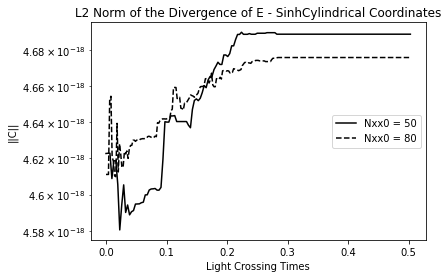

In [27]:
# Plotting the constraint violation
nrpy_div_low = np.loadtxt(os.path.join(outdir,'out-lowresolution.txt')).T
nrpy_div_med = np.loadtxt(os.path.join(outdir,'out-medresolution.txt')).T

plt.plot(nrpy_div_low[0]/domain_size, (nrpy_div_low[1]), 'k-',label='Nxx0 = '+Nxx0_low)
plt.plot(nrpy_div_med[0]/domain_size, (nrpy_div_med[1]), 'k--',label='Nxx0 = '+Nxx0_med)

plt.yscale('log')
plt.xlabel('Light Crossing Times')
plt.ylabel('||C||')
# plt.xlim(0,2.2)
# plt.ylim(1e-4, 1e-5)
plt.title('L2 Norm of the Divergence of E - '+par.parval_from_str("reference_metric::CoordSystem")+' Coordinates')
plt.legend(loc='center right')
plt.show()

<a id='latex_pdf_output'></a>

# Step 9: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Curvilinear.pdf](Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Curvilinear.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [28]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Curvilinear")

Created Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-
    Curvilinear.tex, and compiled LaTeX file to PDF file Tutorial-
    Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Curvilinear.pdf
